# Cell type deconvolution using STitch3D for DLPFC
For low resolution data, Harmonics needs cell type proportion for each spot to define niches. Here, we use our previouly proposed method, STitch3D to obtain the cell type deconvolution results. Find more details at https://github.com/YangLabHKUST/STitch3D.

### Load the packages

In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import anndata as ad
import seaborn as sns
import scipy.io
import matplotlib.pyplot as plt
import os
import sys

import STitch3D

import warnings
warnings.filterwarnings("ignore")

os.environ["CUDA_VISIBLE_DEVICES"] = "7"

/home/yliuow/.conda/envs/STitch3D/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_dir = '../../../Data/Spatial/Transcriptomics/Visium_DLPFC_Maynard2021/'
save_dir = '../../results/Visium_DLPFC_Maynard2021/STitch3D/'
os.makedirs(save_dir, exist_ok=True)

### Load dataset

In [3]:
iter = 0
g = 'g2'
groups = {'g1': ['151507', '151508', '151509', '151510'], 
          'g2': ['151669', '151670', '151671', '151672'], 
          'g3': ['151673', '151674', '151675', '151676']}
slice_name_list = groups[g]

adata_list = []
for slice_name in slice_name_list:
    adata = ad.read_h5ad(data_dir + f'{slice_name}/{slice_name}_adata.h5ad')
    adata = adata[adata.obs['Manual_Annotation'].notna(), :].copy()  # filter out cells without annotation

    # find and remove mitochondria-encoded (MT) genes
    adata.var['MT_gene'] = [gene.startswith('MT-') or gene.startswith('mt-') for gene in adata.var_names.tolist()]
    adata = adata[:, ~adata.var['MT_gene'].values].copy()
    sc.pp.filter_genes(adata, min_counts=1)
    print(adata.shape)

    adata.obs['array_row'] = adata.obsm['spatial'][:, 1].copy()  # used for alignment
    adata.obs['array_col'] = adata.obsm['spatial'][:, 0].copy()  # used for alignment
    adata_list.append(adata)

(3636, 21216)
(3484, 20999)
(4093, 21610)
(3888, 21283)


#### Single cell reference for cell type deconvolution

In [ ]:
mat = scipy.io.mmread(data_dir+"/sc_ref/GSE144136_GeneBarcodeMatrix_Annotated.mtx")
meta = pd.read_csv(data_dir+"/sc_ref/GSE144136_CellNames.csv", index_col=0)
meta.index = meta.x.values
group = [i.split('.')[1].split('_')[0] for i in list(meta.x.values)]
condition = [i.split('.')[1].split('_')[1] for i in list(meta.x.values)]
celltype = [i.split('.')[0] for i in list(meta.x.values)]
meta["group"] = group
meta["condition"] = condition
meta["celltype"] = celltype
genename = pd.read_csv(data_dir+"/sc_ref/GSE144136_GeneNames.csv", index_col=0)
genename.index = genename.x.values
adata_ref = ad.AnnData(X=mat.tocsr().T)
adata_ref.obs = meta
adata_ref.var = genename
adata_ref = adata_ref[adata_ref.obs.condition.values.astype(str)=="Control", :]
adata_ref

In [ ]:
adata_ref.write_h5ad(save_dir + "adata_ref.h5ad")
adata_ref = ad.read_h5ad(save_dir + "adata_ref.h5ad")
sc.pp.filter_genes(adata_ref, min_counts=1)
adata_ref

AnnData object with n_obs × n_vars = 35212 × 29437
    obs: 'x', 'group', 'condition', 'celltype'
    var: 'x', 'n_counts'

In [6]:
adata_ref.obs['celltype'].value_counts()

Ex_10_L2_4       8464
Ex_3_L4_5        3629
Oligos_3         2957
Astros_2         1886
Inhib_2_VIP      1750
Ex_5_L5          1644
Ex_7_L4_6        1422
Inhib_5          1387
Mix_5             974
Inhib_6_SST       970
Inhib_1           962
Mix_2             947
Ex_6_L4_6         901
Ex_2_L5           895
OPCs_1            833
Ex_8_L5_6         822
Inhib_7_PVALB     692
Micro/Macro       542
Astros_3          512
Ex_1_L5_6         351
Inhib_3_SST       344
OPCs_2            324
Ex_4_L_6          320
Inhib_8_PVALB     307
Mix_4             269
Astros_1          234
Oligos_1          215
Endo              192
Mix_3             186
Mix_1             136
Ex_9_L5_6         107
Oligos_2           28
Inhib_4_SST        10
Name: celltype, dtype: int64

### Run STitch3D

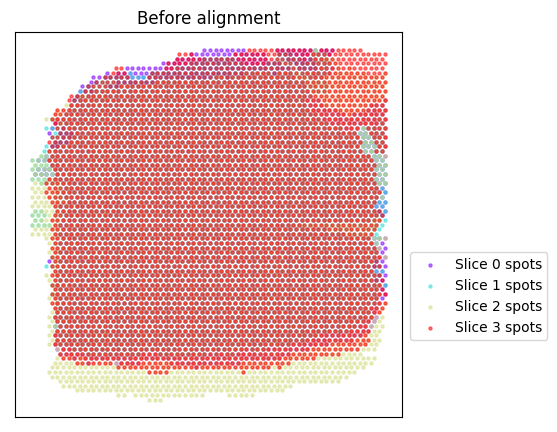

Using the Iterative Closest Point algorithm for alignemnt.
Detecting edges...


Aligning edges...


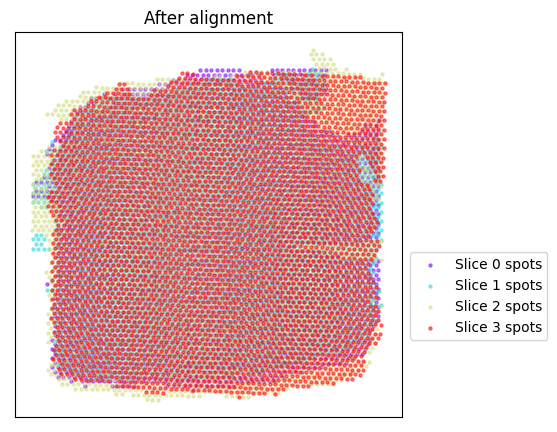

In [7]:
adata_list = STitch3D.utils.align_spots(adata_list, plot=True)

In [8]:
celltype_list_use = ['Astros_1', 'Astros_2', 'Astros_3', 
                     'Endo', 
                     'Ex_10_L2_4', 'Ex_1_L5_6', 'Ex_2_L5', 'Ex_3_L4_5', 'Ex_4_L_6', 'Ex_5_L5', 
                     'Ex_6_L4_6', 'Ex_7_L4_6', 'Ex_8_L5_6', 'Ex_9_L5_6',
                     'Micro/Macro', 
                     'Oligos_1', 'Oligos_2', 'Oligos_3']

adata_st, adata_basis = STitch3D.utils.preprocess(adata_list,
                                                  adata_ref,
                                                  celltype_ref=celltype_list_use,
                                                  sample_col="group",
                                                  slice_dist_micron=[10., 300., 10.],
                                                  n_hvg_group=500)

Finding highly variable genes...


4486 highly variable genes selected.
Calculate basis for deconvolution...
1 batches are used for computing the basis vector of cell type <Astros_1>.
17 batches are used for computing the basis vector of cell type <Astros_2>.
14 batches are used for computing the basis vector of cell type <Astros_3>.
17 batches are used for computing the basis vector of cell type <Endo>.
17 batches are used for computing the basis vector of cell type <Ex_10_L2_4>.
15 batches are used for computing the basis vector of cell type <Ex_1_L5_6>.
15 batches are used for computing the basis vector of cell type <Ex_2_L5>.
17 batches are used for computing the basis vector of cell type <Ex_3_L4_5>.
14 batches are used for computing the basis vector of cell type <Ex_4_L_6>.
17 batches are used for computing the basis vector of cell type <Ex_5_L5>.
16 batches are used for computing the basis vector of cell type <Ex_6_L4_6>.
16 batches are used for computing the basis vector of cell type <Ex_7_L4_6>.
15 batches are 

In [9]:
model = STitch3D.model.Model(adata_st, adata_basis, training_steps=20000, seed=1234+iter)

model.train()

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 2/20000 [00:01<2:49:52,  1.96it/s]

Step: 0, Loss: 2436.2102, d_loss: 2430.6494, f_loss: 55.6071


 10%|█         | 2002/20000 [04:12<37:45,  7.94it/s]

Step: 2000, Loss: 886.1773, d_loss: 882.7501, f_loss: 34.2726


 20%|██        | 4002/20000 [08:25<33:35,  7.94it/s]

Step: 4000, Loss: 836.1738, d_loss: 832.7691, f_loss: 34.0468


 30%|███       | 6002/20000 [12:38<29:20,  7.95it/s]

Step: 6000, Loss: 833.8516, d_loss: 830.4614, f_loss: 33.9023


 40%|████      | 8002/20000 [16:50<25:00,  7.99it/s]

Step: 8000, Loss: 830.0183, d_loss: 826.6381, f_loss: 33.8021


 50%|█████     | 10002/20000 [21:01<20:50,  8.00it/s]

Step: 10000, Loss: 826.6379, d_loss: 823.2683, f_loss: 33.6959


 60%|██████    | 12002/20000 [25:12<16:39,  8.01it/s]

Step: 12000, Loss: 824.5912, d_loss: 821.2294, f_loss: 33.6184


 70%|███████   | 14002/20000 [29:23<12:23,  8.06it/s]

Step: 14000, Loss: 823.6375, d_loss: 820.2796, f_loss: 33.5789


 80%|████████  | 16002/20000 [33:34<08:14,  8.09it/s]

Step: 16000, Loss: 823.1537, d_loss: 819.7984, f_loss: 33.5535


 90%|█████████ | 18002/20000 [37:45<04:10,  7.98it/s]

Step: 18000, Loss: 822.6957, d_loss: 819.3434, f_loss: 33.5237


100%|██████████| 20000/20000 [41:56<00:00,  7.95it/s]


In [10]:
result = model.eval(adata_list, save=False)

In [11]:
result

[AnnData object with n_obs × n_vars = 3636 × 21216
     obs: 'in_tissue', 'x', 'y', 'image_row', 'image_col', 'imagerow', 'imagecol', 'Manual_Annotation', 'array_row', 'array_col', 'Astros_1', 'Astros_2', 'Astros_3', 'Endo', 'Ex_10_L2_4', 'Ex_1_L5_6', 'Ex_2_L5', 'Ex_3_L4_5', 'Ex_4_L_6', 'Ex_5_L5', 'Ex_6_L4_6', 'Ex_7_L4_6', 'Ex_8_L5_6', 'Ex_9_L5_6', 'Micro/Macro', 'Oligos_1', 'Oligos_2', 'Oligos_3'
     var: 'gene_ids', 'feature_types', 'genome', 'MT_gene', 'n_counts'
     obsm: 'radius', 'spatial', 'spatial_img', 'spatial_aligned',
 AnnData object with n_obs × n_vars = 3484 × 20999
     obs: 'in_tissue', 'x', 'y', 'image_row', 'image_col', 'imagerow', 'imagecol', 'Manual_Annotation', 'array_row', 'array_col', 'Astros_1', 'Astros_2', 'Astros_3', 'Endo', 'Ex_10_L2_4', 'Ex_1_L5_6', 'Ex_2_L5', 'Ex_3_L4_5', 'Ex_4_L_6', 'Ex_5_L5', 'Ex_6_L4_6', 'Ex_7_L4_6', 'Ex_8_L5_6', 'Ex_9_L5_6', 'Micro/Macro', 'Oligos_1', 'Oligos_2', 'Oligos_3'
     var: 'gene_ids', 'feature_types', 'genome', 'MT_gene', '

### Save the data

In [ ]:
start = 0
for i, slice_name in enumerate(slice_name_list):

    end = start+result[i].shape[0]
    result[i].obsm['latent'] = model.adata_st[start:end, :].obsm['latent'].copy()
    start = end
    
    result[i].write_h5ad(save_dir + f'{slice_name}_STitch3D.h5ad')